# Importing stuffs

In [1]:
from scipy.signal import convolve2d
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [12]:
originalImg = np.asarray(Image.open("sampleImage/robert.jpg"))
originalImg = cv2.resize(originalImg,(500,600))

In [4]:
def plot_img(img,title):
    plt.imshow(img,cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()
    
def plot_countour(img):
    plt.contourf(img,cmap="coolwarm")
    plt.colorbar()
    plt.show()

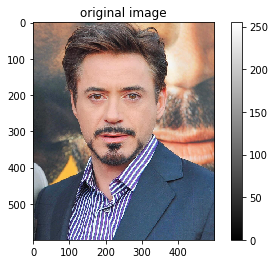

In [13]:
plot_img(originalImg,title="original image")

# Some image processing and minipulation using opencv

### Gaussian blur using opencv

In [14]:
gausianBlurImg = cv2.GaussianBlur(originalImg,(21,21),5)

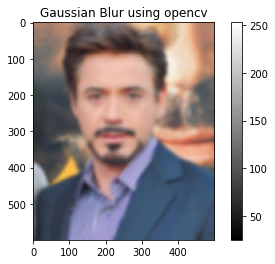

In [15]:
plot_img(gausianBlurImg,title="Gaussian Blur using opencv")

### Applying some filters using opencv

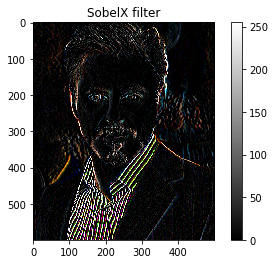

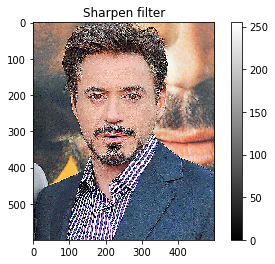

In [16]:
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")


plot_img(cv2.filter2D(originalImg,-1,sobelX),title="SobelX filter")
plot_img(cv2.filter2D(originalImg,-1,sharpen),title="Sharpen filter")

# Image to sketch step by step using just numpy.

- note:- 

## 1. Converting RGB image to Grayscale image

- Steps to convert RGB image to Grayscale
	* RGB weights = [0.2126*R,0.7152*G,0.0722*B]
	* We take the dot product of each channel values with rgb weigths
	* The weigths is used to correct the perceptual luminance of the channels

In [72]:
def RGB2GRAY(img):
    if len(np.squeeze(img).shape) == 2:
        print("already in grayscale")
        return img
    else:
        rgb_weights = np.array([0.2126,0.7152,0.0722])
        return np.dot(img[...,:3],rgb_weights)

    

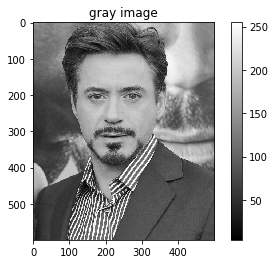

In [18]:
grayImage = RGB2GRAY(originalImg)
plot_img(grayImage,"gray image")

In [19]:
grayImage.shape

(600, 500)

## 2. Inverting an Image.

- step to invert the Grayscale/RGB image i.e convert the image to negative image.
    * Subtract each pixel value from the maximum pixel value from the image.
    * max(img) - img where img is a numpy.ndarray
    

In [20]:
def invert_image(img):
    return img.max() - img

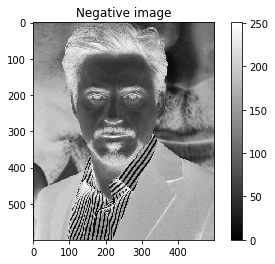

In [21]:
negativeImage = invert_image(grayImage)
plot_img(negativeImage, title="Negative image")

## 3. Applying Gaussian Blur to negative/inverted image.

- Steps to blurr/smooth an image using gaussian filter.
    * Generate a Gaussian Kernel/filter(a square matrix) of given size.
    * Normalize pixel value of the inverted/negative image with in the range of $(0,1)$.
    * Convolve the kernel/filter with the normalized image.
    * After convolution operation on image we again denormalize it in range $(0,255)$

### Generating gaussian kernel.

- we create a gaussian kernel/filter(square matrix) using Gaussian distribution function.
- the Gaussian aka Normal distribution function is given as:

    $\small f(x,\mu , \sigma )=\frac{1}{\sigma \sqrt{2\pi}}\; e^{\frac{-(x- \mu)^{2}}{2\sigma ^{2}}}$
    
    Where,

    $x$ is the variable

    $\mu$ is the mean

    $\sigma$ is the standard deviation

In [22]:
def gaussian_distribution(x,mu,sigma):
    return 1 / (np.sqrt(2 * np.pi) * sigma) * np.exp(-np.power((x - mu) / sigma, 2) / 2)

def gausianKernel(size,sigma=1,mu=0):
    kernel_1d = np.linspace(-(size//2),size//2,size)
    kernel_1d = gaussian_distribution(kernel_1d,mu,sigma)
    
    kernel_2d = np.outer(kernel_1d.T,kernel_1d)
    kernel_2d *= 1.0/kernel_2d.max() 
    return kernel_2d


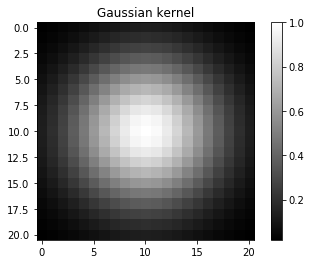

array([[0.49935179, 0.70664828, 0.49935179],
       [0.70664828, 1.        , 0.70664828],
       [0.49935179, 0.70664828, 0.49935179]])

In [23]:
plot_img(gausianKernel(21,sigma=5),"Gaussian kernel")
gausianKernel(3,1.2)

### Convolving image with kernel 

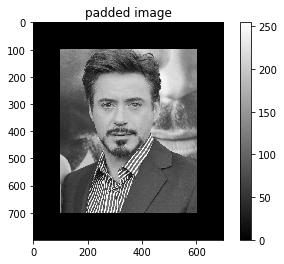

In [24]:
def pad_image(img,pad_width=1):
    '''Padding for just grayscale images'''
    padded_img = np.zeros((img.shape[0] + pad_width*2, img.shape[1]+pad_width*2))
    padded_img[pad_width:-pad_width,pad_width:-pad_width] = img
    return padded_img

plot_img(pad_image(grayImage,pad_width=100),"padded image")

In [25]:
def normalize_img(img,range_end = 1):
    '''range end cannot be 0'''
    return (img/img.max())*range_end

In [13]:
def conv2D(img,kernel):
    '''Naive approach to convolve the image with filter. Takes hell lot of time'''
    kernel_size = kernel.shape[0]
    convolved_output = np.zeros_like(img)
    
    padded_image = pad_image(img,pad_width=kernel_size-2)
    
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            convolved_output[y,x] = (kernel * padded_image[y:y+kernel_size,x:x+kernel_size]).sum()
            
    return convolved_output    
    

#### using naive approach

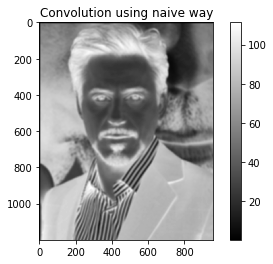

CPU times: user 10.4 s, sys: 30.4 ms, total: 10.4 s
Wall time: 10.4 s


In [18]:
%%time
gaussian_kernel = gausianKernel(15,sigma=5)
image = normalize_img(negativeImage)
plot_img(conv2D(image,gaussian_kernel),"Convolution using naive way")


#### using scipy convolve2d

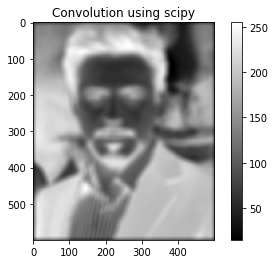

CPU times: user 892 ms, sys: 0 ns, total: 892 ms
Wall time: 890 ms


In [56]:
%%time
kernel = gausianKernel(21,sigma=10)
blurNegative = convolve2d(negativeImage,kernel,mode="same")
plot_img(normalize_img(blurNegative,range_end=255.0),"Convolution using scipy")

## 4.Blending grayscale image with blurred negative image.

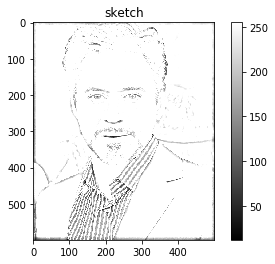

In [57]:
def dodge(negative_blur,grayimage): 
    result = grayimage/((1.0 - negative_blur)+10e-12)
    result[result>1.0] = 1.0
    result = normalize_img(result,range_end=255.0)
    return result
blurNegative = normalize_img(blurNegative)
grayImage = normalize_img(grayImage)
blurGray = normalize_img(blurGray)
Dblend = dodge(blurNegative,grayImage)
plot_img(Dblend,"sketch")

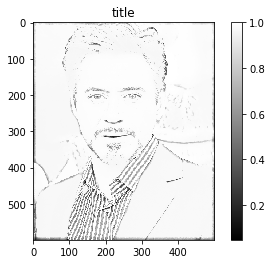

In [77]:
def burn(Dblend,grayimg):
    result = (normalize_img(Dblend)) + (1.0/25*grayimg)
    result = normalize_img(result)
    return result

plot_img(burn(Dblend,grayImage),"title")